# **FULL DATASET MULTICLASS**
### **Preliminary steps**

In [1]:
import os 
print(os.getcwd())
os.chdir('../..')
print(os.getcwd())

/Users/Corentin/Desktop/ENSAE 2024-2025/S2/NLP/final project /ml-for-nlp/analysis/notebooks
/Users/Corentin/Desktop/ENSAE 2024-2025/S2/NLP/final project /ml-for-nlp


In [2]:
### PACKAGES
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import numpy as np

In [3]:
### FUNCTIONS

from src.configs import constants, ml_config, names
from src.libs import preprocessing, evaluation, visualization

In [4]:
### LOAD DATA

df_poetry_gpt = preprocessing.load_dataset(source="GPT", type="POETRY")
df_poetry_bard = preprocessing.load_dataset(source="BARD", type="POETRY")
df_poetry_human = preprocessing.load_dataset(source="Human", type="POETRY")

df_essay_gpt = preprocessing.load_dataset(source="GPT", type="ESSAY")
df_essay_bard = preprocessing.load_dataset(source="BARD", type="ESSAY")
df_essay_human = preprocessing.load_dataset(source="Human", type="ESSAY")

df_story_gpt = preprocessing.load_dataset(source="GPT", type="STORY")
df_story_bard = preprocessing.load_dataset(source="BARD", type="STORY")
df_story_human = preprocessing.load_dataset(source="Human", type="STORY")

Time taken to load dataset: 0.019136905670166016 seconds
Time taken to load dataset: 0.00980377197265625 seconds
Time taken to load dataset: 0.3781249523162842 seconds
Time taken to load dataset: 0.008750200271606445 seconds
Time taken to load dataset: 0.006359100341796875 seconds
Time taken to load dataset: 0.08651900291442871 seconds
Time taken to load dataset: 0.011983156204223633 seconds
Time taken to load dataset: 0.011091947555541992 seconds
Time taken to load dataset: 0.01294088363647461 seconds


In [5]:
### GROUPED LLM 
df_poetry = preprocessing.get_poetry_dataset(
        df_poetry_gpt,
        df_poetry_bard,
        df_poetry_human,
        samples_per_source=min(
            len(df_poetry_gpt),
            len(df_poetry_bard),
            len(df_poetry_human),
        ),
    )

df_essay = preprocessing.get_essay_dataset(
        df_essay_gpt,
        df_essay_bard,
        df_essay_human,
        samples_per_source=min(
            len(df_essay_gpt), len(df_essay_bard), len(df_essay_human)
        ),
    )

df_story = preprocessing.get_story_dataset(
        df_story_gpt,
        df_story_bard,
        df_story_human,
        samples_per_source=min(
            len(df_story_gpt), len(df_story_bard), len(df_story_human)
        ),
    )


# ### GROUPED LLM 
# df_poetry = preprocessing.get_poetry_dataset(
#         df_poetry_gpt,
#         df_poetry_bard,
#         df_poetry_human,
#         samples_per_source=None,
#     )

# df_essay = preprocessing.get_essay_dataset(
#         df_essay_gpt,
#         df_essay_bard,
#         df_essay_human,
#         samples_per_source=None,
#     )

# df_story = preprocessing.get_story_dataset(
#         df_story_gpt,
#         df_story_bard,
#         df_story_human,
#         samples_per_source=None,
#     )



In [6]:
### GET TRAIN SPLIT

df_train_poetry, df_test_poetry = preprocessing.train_valid_split(df_poetry)
df_train_essay, df_test_essay = preprocessing.train_valid_split(df_essay)
df_train_story, df_test_story = preprocessing.train_valid_split(df_story)

df_train_poetry_gpt, df_test_poetry_gpt = df_train_poetry[df_train_poetry.label==1].copy(), df_test_poetry[df_test_poetry.label==1].copy()
df_train_poetry_bard, df_test_poetry_bard = df_train_poetry[df_train_poetry.label==2].copy(), df_test_poetry[df_test_poetry.label==2].copy()
df_train_poetry_human, df_test_poetry_human = df_train_poetry[df_train_poetry.label==0].copy(), df_test_poetry[df_test_poetry.label==0].copy()


df_train_story_gpt, df_test_story_gpt = df_train_story[df_train_story.label==1].copy(), df_test_story[df_test_story.label==1].copy()
df_train_story_bard, df_test_story_bard = df_train_story[df_train_story.label==2].copy(), df_test_story[df_test_story.label==2].copy()
df_train_story_human, df_test_story_human = df_train_story[df_train_story.label==0].copy(), df_test_story[df_test_story.label==0].copy()

df_train_essay_gpt, df_test_essay_gpt = df_train_essay[df_train_essay.label==1].copy(), df_test_essay[df_test_essay.label==1].copy()
df_train_essay_bard, df_test_essay_bard = df_train_essay[df_train_essay.label==2].copy(), df_test_essay[df_test_essay.label==2].copy()
df_train_essay_human, df_test_essay_human = df_train_essay[df_train_essay.label==0].copy(), df_test_essay[df_test_essay.label==0].copy()

In [7]:
### CONCATENATE ALL DATASETS

df_train = pd.concat([df_train_poetry, df_train_essay, df_train_story], axis=0).sample(
    frac=1
)
df_test = pd.concat([df_test_poetry, df_test_essay, df_test_story], axis=0).sample(
    frac=1
)

In [8]:
### SPLIT FEATURES AND LABELS

X_train, y_train = preprocessing.split_features_and_labels(df_train)
X_test, y_test = preprocessing.split_features_and_labels(df_test)
X_test_poetry, y_test_poetry = preprocessing.split_features_and_labels(df_test_poetry)
X_test_essay, y_test_essay = preprocessing.split_features_and_labels(df_test_essay)
X_test_story, y_test_story = preprocessing.split_features_and_labels(df_test_story)

## **CLASSIFICATION USING PUNCTUATION & RANDOM FOREST**

In [9]:
def punctuation_transform(X: np.ndarray) -> np.ndarray:

    X_series = pd.Series(X).astype(str)
    array_nb_characters = X_series.str.len().to_numpy()

    array_ratio_punctuations = (
        X_series.str.count(r"[^\w\s]").to_numpy() / array_nb_characters
    )
    array_ratio_words_per_sentence = (
        X_series.str.count(r"[.!?]").to_numpy()
        / X_series.str.split().str.len().to_numpy()
    )
    array_ratio_odd_characters = (
        X_series.str.count(r"[!;-_]").to_numpy() / array_nb_characters
    )

    embedding = pd.DataFrame(
        {
            "ratio_punctuations": array_ratio_punctuations,
            "ratio_words_per_sentence": array_ratio_words_per_sentence,
            "ratio_odd_characters": array_ratio_odd_characters,
        }
    ).to_numpy()

    return embedding

def punctuation_map_dimensions_to_names() -> np.ndarray:
    return np.array([
        "ratio_punctuations",
        "ratio_words_per_sentence",
        "ratio_odd_characters"
    ])


In [21]:
def evaluate(model, X, y, display_labels=None, title=None):
    """
    Evaluate a model, display the confusion matrix, and return evaluation scores.

    Args:
        model: Trained sklearn-like model.
        X (np.ndarray): Input features.
        y (np.ndarray): True labels.
        display_labels (list, optional): Class names for display.

    Returns:
        dict: Dictionary containing confusion matrix, precision, recall, f1 score.
    """
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)

    if display_labels is None:
        classes = np.unique(np.concatenate([y, y_pred]))
        display_labels = [str(label) for label in classes]

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=display_labels, yticklabels=display_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for {title}")
    plt.tight_layout()
    plt.show()

    return {
        "confusion_matrix": cm,
        "precision": precision_score(y, y_pred, average="macro"),
        "recall": recall_score(y, y_pred, average="macro"),
        "f1": f1_score(y, y_pred, average="macro")
    }


In [22]:
### EMBEDDING

X_train_211 = punctuation_transform(X_train)
X_test_211 = punctuation_transform(X_test)
X_test_poetry_211 = punctuation_transform(X_test_poetry)
X_test_essay_211 = punctuation_transform(X_test_essay)
X_test_story_211 = punctuation_transform(X_test_story)

In [23]:
### Random search 

param_distributions = {
    "n_estimators": randint(50, 300),
    "max_depth": randint(3, 20),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 10),
    "bootstrap": [True, False],
}

base_rf = RandomForestClassifier(n_jobs=-1, random_state=42)


search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_distributions,
    n_iter=50,  
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train_211, y_train)

best_rf = search.best_estimator_

print("Best hyperparameters:", search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 170}


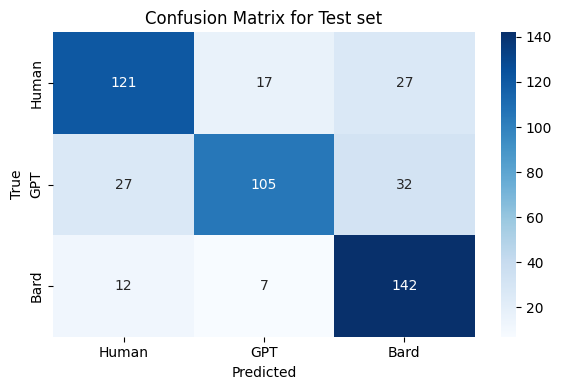

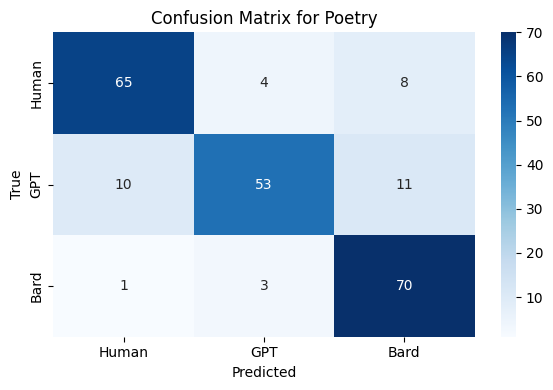

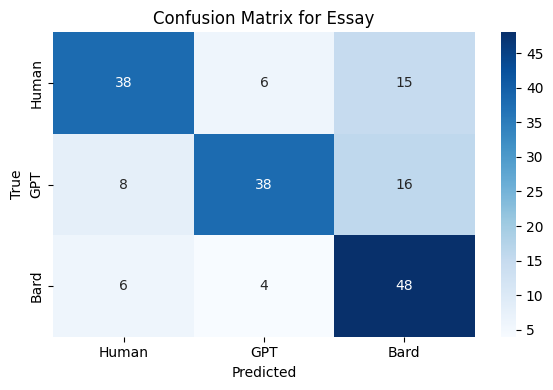

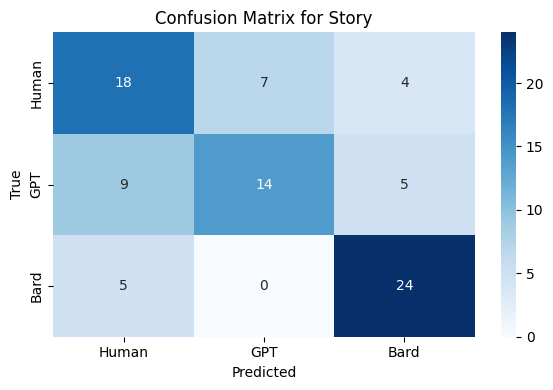

                                    confusion_matrix precision    recall  \
test    [[121, 17, 27], [27, 105, 32], [12, 7, 142]]   0.75889  0.751855   
poetry        [[65, 4, 8], [10, 53, 11], [1, 3, 70]]  0.841704  0.835439   
essay         [[38, 6, 15], [8, 38, 16], [6, 4, 48]]   0.71001  0.694852   
story           [[18, 7, 4], [9, 14, 5], [5, 0, 24]]  0.652146  0.649425   

              f1  
test    0.748623  
poetry  0.833205  
essay   0.692108  
story   0.645262  


In [24]:
### CLASSIFIER

best_rf.fit(X_train_211, y_train)


# Evaluation
metrics_211 = evaluate(best_rf, X_test_211, y_test, display_labels=["Human", "GPT", "Bard"], title="Test set")
metrics_poetry_211 = evaluate(best_rf, X_test_poetry_211, y_test_poetry, display_labels=["Human", "GPT", "Bard"], title="Poetry")
metrics_essay_211 = evaluate(best_rf, X_test_essay_211, y_test_essay, display_labels=["Human", "GPT", "Bard"], title="Essay")
metrics_story_211 = evaluate(best_rf, X_test_story_211, y_test_story, display_labels=["Human", "GPT", "Bard"], title="Story")

results = {
    "test": metrics_211,
    "poetry": metrics_poetry_211,
    "essay": metrics_essay_211,
    "story": metrics_story_211
}
df_metrics = pd.DataFrame(results).T 
print(df_metrics.round(3)) 


In [25]:
### INTERPRETABILITY - FEATURE IMPORTANCE

dim_names_211 = punctuation_map_dimensions_to_names()
feature_importances_211 = best_rf.feature_importances_

most_important_features_211 = np.argsort(feature_importances_211)[-10:][::-1]

for i in most_important_features_211:
    print(f"{dim_names_211[i]}: {feature_importances_211[i]}")


ratio_words_per_sentence: 0.3681277787627618
ratio_odd_characters: 0.3396094899108072
ratio_punctuations: 0.29226273132643105


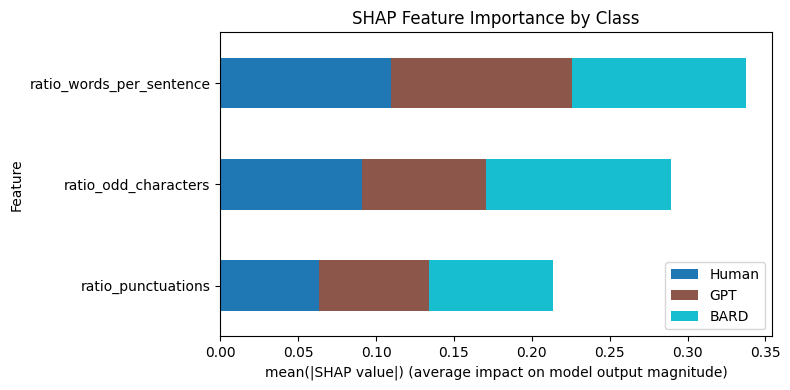

In [38]:
### INTERPRETABILITY - SHAP VALUES

explainer_211 = shap.Explainer(best_rf)
X_test_211_dense = X_test_211
shap_values_211 = explainer_211(X_test_211_dense)
mean_abs_shap_values = np.mean(np.abs(shap_values_211.values), axis=2)

class_names = ["Human", "GPT", "BARD"]

mean_abs_shap_per_class = np.mean(np.abs(shap_values_211.values), axis=0)  # shape (n_features, n_classes)

df_shap = pd.DataFrame(mean_abs_shap_per_class, columns=class_names)
df_shap["Feature"] = dim_names_211
df_shap["Total"] = df_shap[class_names].sum(axis=1)
df_shap = df_shap.sort_values("Total").drop(columns="Total")

df_shap.set_index("Feature").plot(kind="barh", stacked=True, figsize=(8, 4), colormap="tab10")
plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
plt.title("SHAP Feature Importance by Class")
plt.tight_layout()
plt.show()

## **CLASSIFICATION USING TF-IDF & RANDOM FOREST**

In [39]:
def fit_tfidf_embedding(X_train_texts, max_features=1000):
    """
    Fit a TF-IDF vectorizer on training texts.

    Args:
        X_train_texts (list or np.ndarray): Training texts.
        max_features (int): Maximum number of features for TF-IDF.

    Returns:
        vectorizer: Fitted TfidfVectorizer instance.
        X_train_tfidf: Transformed training data.
    """
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        smooth_idf=True,
        stop_words="english"
    )
    X_train_tfidf = vectorizer.fit_transform(X_train_texts)
    return vectorizer, X_train_tfidf

def transform_with_tfidf(vectorizer, X_texts):
    """
    Transform texts using an already fitted TF-IDF vectorizer.

    Args:
        vectorizer: A fitted TfidfVectorizer.
        X_texts (list or np.ndarray): Texts to transform.

    Returns:
        X_tfidf: Transformed TF-IDF matrix.
    """
    return vectorizer.transform(X_texts)


In [40]:
### TF-IDF embedding
vectorizer_tfidf, X_train_tfidf = fit_tfidf_embedding(X_train, max_features=1000)

X_test_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test)
X_test_poetry_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_poetry)
X_test_essay_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_essay)
X_test_story_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_story)

In [41]:
base_rf = RandomForestClassifier(n_jobs=-1, random_state=42)


search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_distributions,
    n_iter=50,  
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train_tfidf, y_train)

best_rf_tfidf = search.best_estimator_

print("Best hyperparameters:", search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 173}


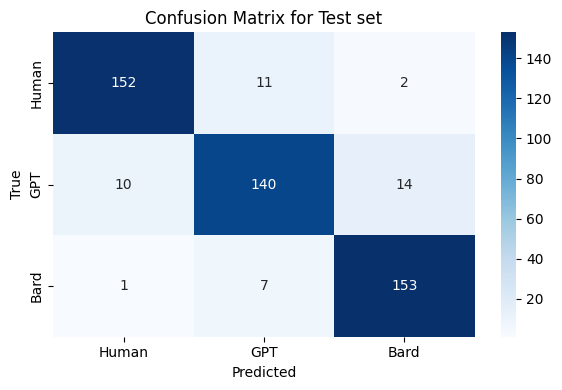

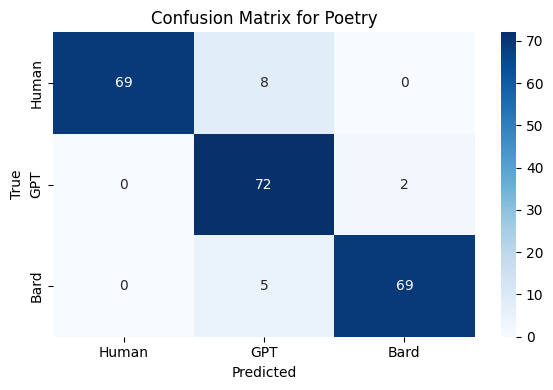

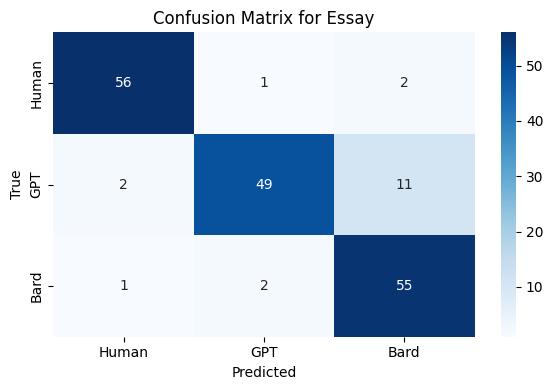

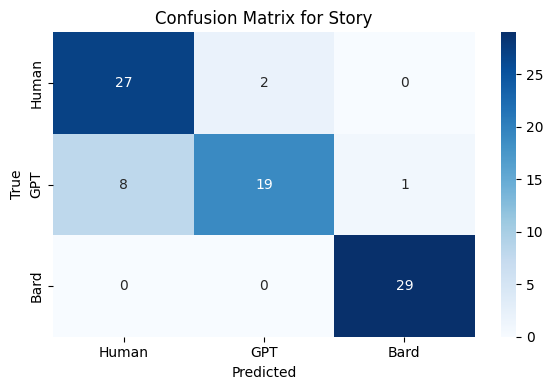

                                  confusion_matrix precision    recall  \
test    [[152, 11, 2], [10, 140, 14], [1, 7, 153]]  0.907972  0.908394   
poetry        [[69, 8, 0], [0, 72, 2], [0, 5, 69]]   0.93963  0.933836   
essay        [[56, 1, 2], [2, 49, 11], [1, 2, 55]]  0.900095  0.895917   
story         [[27, 2, 0], [8, 19, 1], [0, 0, 29]]  0.880952  0.869869   

              f1  
test    0.907889  
poetry  0.934197  
essay   0.893939  
story   0.867437  


In [42]:
### CLASSIFIER

best_rf_tfidf.fit(X_train_tfidf, y_train)

# Evaluation
metrics_tfidf = evaluate(best_rf_tfidf, X_test_tfidf, y_test, display_labels=["Human", "GPT", "Bard"], title="Test set")
metrics_poetry_tfidf = evaluate(best_rf_tfidf, X_test_poetry_tfidf, y_test_poetry, display_labels=["Human", "GPT", "Bard"], title="Poetry")
metrics_essay_tfidf = evaluate(best_rf_tfidf, X_test_essay_tfidf, y_test_essay, display_labels=["Human", "GPT", "Bard"], title="Essay")
metrics_story_tfidf = evaluate(best_rf_tfidf, X_test_story_tfidf, y_test_story, display_labels=["Human", "GPT", "Bard"], title="Story")

results = {
    "test": metrics_tfidf,
    "poetry": metrics_poetry_tfidf,
    "essay": metrics_essay_tfidf,
    "story": metrics_story_tfidf
}
df_metrics = pd.DataFrame(results).T 
print(df_metrics.round(3)) 


In [43]:
### INTERPRETABILITY - FEATURE IMPORTANCE

dim_names_tfidf = vectorizer_tfidf.get_feature_names_out()
feature_importances_tfidf = best_rf_tfidf.feature_importances_
most_important_features_tfidf = np.argsort(feature_importances_tfidf)[-20:][::-1]
for i in most_important_features_tfidf:
    print(f"{dim_names_tfidf[i]}: {feature_importances_tfidf[i]:.5f}")


really: 0.02067
like: 0.01825
oh: 0.01452
believe: 0.01420
just: 0.01278
help: 0.01240
hope: 0.01189
think: 0.01187
world: 0.01135
don: 0.01085
room: 0.01071
going: 0.00982
father: 0.00881
heart: 0.00856
mother: 0.00819
man: 0.00803
got: 0.00801
make: 0.00759
right: 0.00752
conclusion: 0.00727


## **BARD**

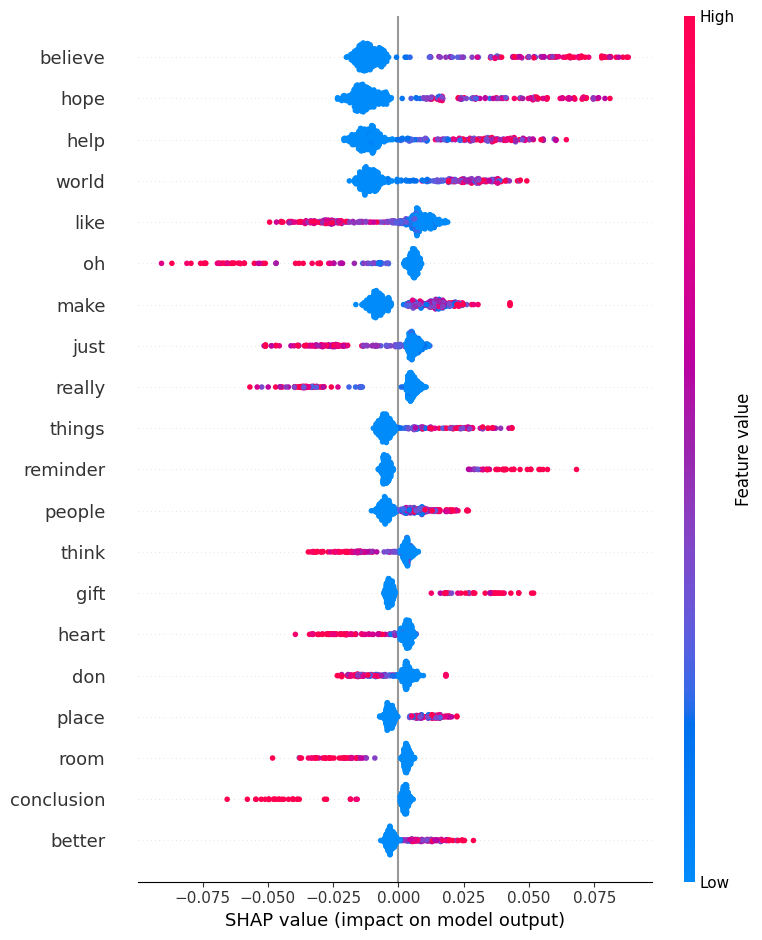

In [48]:
### INTERPRETABILITY - SHAP VALUES

X_test_tfidf_dense = X_test_tfidf.toarray()
explainer_tfidf = shap.TreeExplainer(best_rf_tfidf)
shap_values_tfidf = explainer_tfidf(X_test_tfidf_dense)

shap.summary_plot(
    shap_values_tfidf[:,:,2],
    features=X_test_tfidf_dense,
    feature_names=dim_names_tfidf,
)

## **GPT**

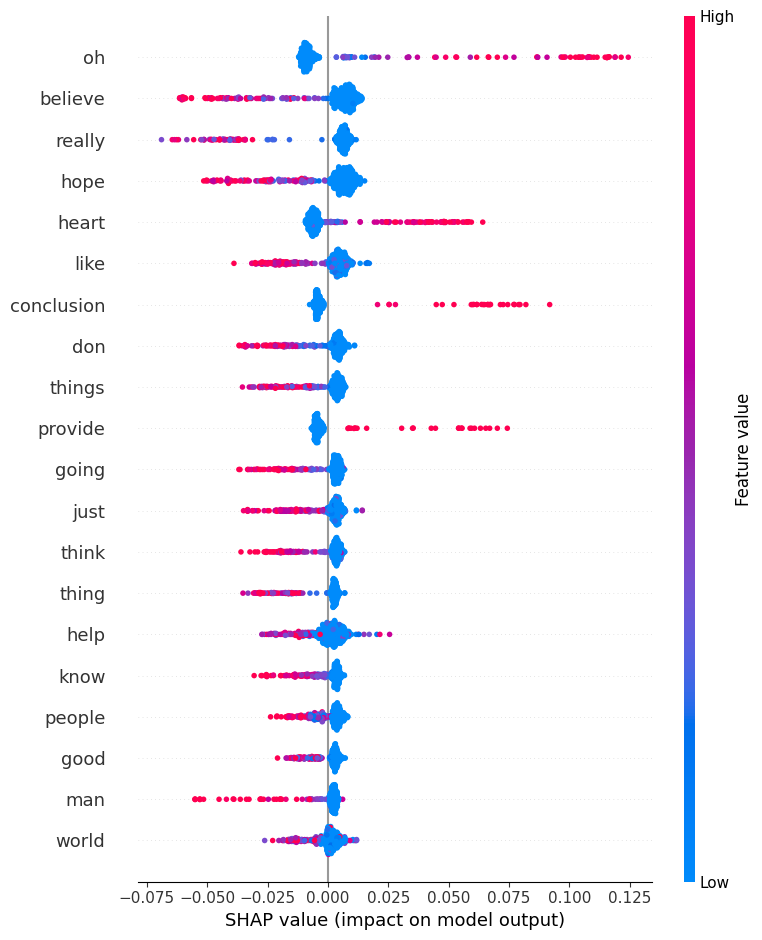

In [49]:
### INTERPRETABILITY - SHAP VALUES

X_test_tfidf_dense = X_test_tfidf.toarray()
explainer_tfidf = shap.TreeExplainer(best_rf_tfidf)
shap_values_tfidf = explainer_tfidf(X_test_tfidf_dense)

shap.summary_plot(
    shap_values_tfidf[:,:,1],
    features=X_test_tfidf_dense,
    feature_names=dim_names_tfidf,
)

## **HUMAN**

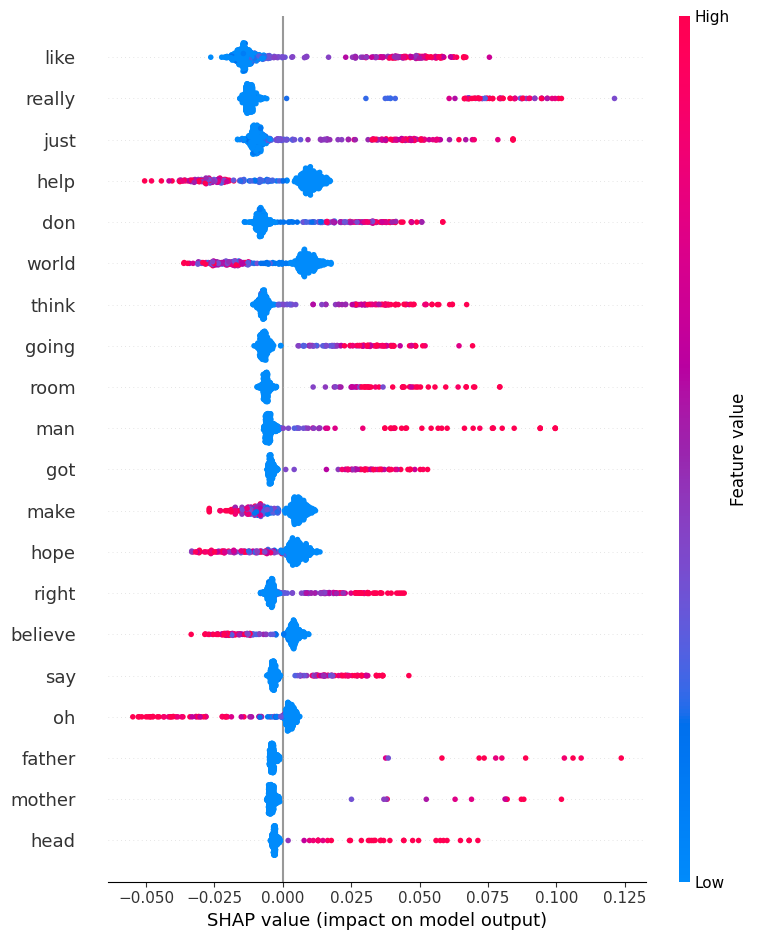

In [50]:
### INTERPRETABILITY - SHAP VALUES

X_test_tfidf_dense = X_test_tfidf.toarray()
explainer_tfidf = shap.TreeExplainer(best_rf_tfidf)
shap_values_tfidf = explainer_tfidf(X_test_tfidf_dense)

shap.summary_plot(
    shap_values_tfidf[:,:,0],
    features=X_test_tfidf_dense,
    feature_names=dim_names_tfidf,
)